# Modelo de detección de clientes de Beta Bank en riesgo de cancelar cuenta.

El objetivo del presente trabajo es construir un modelo predictivo de aprendizaje supervisado para detectar clientes de Beta Bank en riesgo de cancelar sus cuentas. 

Se examina una base de datos de clientes actuales o pasados que contiene identificador de cliente, apellido, edad, género, país, balance, número de productos, score crediticio, salario estimado, si tiene una tarjeta de crédito, si es cliente activo y si ha cancelado su cuenta. Esta base de datos se segmenta para entrenamiento, validación y prueba. Se consideran tres modelos: **Regresión Logística, Árbol de Decisión y Bosque Aleatorio.** Para cada modelo se realizan codificación, estandarización y escalado de datos. Posteriormente se hace una exploración para optimizar los hiperparámetrs sin considerar el desequilibrio de clases. Se mejoran los modelos utilizando diferentes enfoques para corregir el desequilibrio. Se calculan y comparan el valor **F1** y la métrica **AUC-ROC** para cada modelo y se elige el modelo final en base a las mejores métricas.

## Importación de paquetes y librerías

Se importan los paquetes necesarios para el desarrollo de este trabajo, principalmente de las librerías pandas y sklearn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve

## Inspección inicial de datos

Se realiza la importación de la base de datos, se visualiza la información y encabezado para detectar tipo de datos inadecuados, datos ausentes, datos duplicados e incongruencias en general.

In [2]:
data = pd.read_csv('datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


La base de datos contiene 10000 entradas, con 14 columnas correspondientes a número de fila, identificador único de cliente, apellido, score crediticio, país, género, edad, período durante el cual ha madurado el depósito a plazo fijo de un cliente en años, balance de cuenta, número de productos, si el cliente tiene tarjeta de crédito, si es cliente activo, salario estimado y si el cliente ha cancelado. Todas las columnas tienen un tipo de dato adecuado. Solo la columna Tenure tiene datos ausentes.

In [5]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Hay 909 datos ausentes en la columna 'Tenure'.

In [6]:
data.duplicated().sum()

0

No hay filas completamente duplicadas.

In [7]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Se muestra la información general de las columnas numéricas. No se detectan incongruencias en los datos. Aproximadamente el 20% de los clientes de la base de datos han cancelado sus servicios en el banco, lo cual sugiere un desequilibrio en las clases. Adicionalmente podemos notar que aproximadamente el 50% de los clientes de la base de datos son clientes activos y el 70% han tenido una tarjeta de crédito. 

En resumen, no se encontraron datos duplicados, tipos de dato inadecuados o inconcruencias graves. Hay 909 datos ausentes en la columna 'Tenure', lo cual puede deberse a que no todos los clientes cuentan con cuenta de plazo fijo, han cancelado o se han perdido los datos. Se reemplazarán los datos ausentes con una medida estadísticamente representativa.

## Preparación de datos

En esta sección se corrigen inconsistencias detectadas en la sección anterior y se preparan los datos para los modelos correspondientes. 

### Valores ausentes

En la sección anterior se detectan 909 datos ausentes en la columna 'Tenure', a continuación se muestra un histograma de esta columna para observar la distribución de los datos. 

<AxesSubplot:xlabel='Tenure', ylabel='Count'>

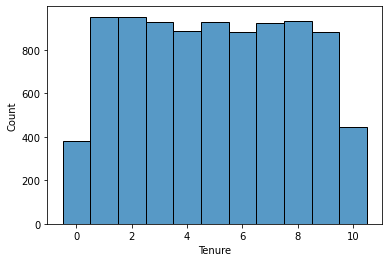

In [8]:
sns.histplot(data=data['Tenure'], discrete=True) 

Se puede observar que la distribución en general es simétrica y va desde los 0 a los 10 años. Adicionalmente en la sección anterior se puede observar que la media y la mediana son muy similares y aproximadamente igual a cinco. Por lo tanto, para mantener los datos como tipo entero se reemplazan los datos ausentes por la mediana.

In [9]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

### Preparación general para el modelado

En este sección se observan todos los datos para optimizar y garantizar la validez de los datos antes de hacer el entrenamiento de los modelos. A continuación se muestran los nombres de las columnas de la base de datos.

In [10]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### Codificación de datos categóricos

La implementación de los modelos requiere que todas las columnas sean de tipo numérico, por lo cual primero debe hacerse una codificación de los datos categóricos, por lo cual es necesario evaluar el tratamiento de estos datos.

El número de fila, identificador de cliente y apellido sirven para identificar al cliente pero en principio no deberían ser consideradas como variables que expliquen si un cliente abandona o no el banco, por lo cual se descartan para el presente análisis, pero de ser necesario se puede reevaluar esta hipótesis posteriormente. 

In [11]:
data = data.drop(columns=['RowNumber','CustomerId','Surname'])

Las columnas correspondientes a género y país son variables categóricas no ordinales, por lo cual se implementa una codificación One-Hot para el modelo de Regresión Logística. Se elimina la primera columna para evitar la dependencia lineal de los vectores.

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True)

Para los modelos de Árbol de decisión y Bosque Aleatorio se emplea una codificación de etiquetas.

In [13]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

### Segmentación de datos

En esta sección se realiza una función que segmenta los datos codificados en conjuntos de entrenamiento, validación y prueba con sus objetivos y características.  La segmentación de datos se realiza de manera que el conjunto de entrenamiento representa el 60% de los datos, y los conjuntos de validación y prueba el 20% cada uno. 

Se define el objetivo como la columna 'Exited' y las características como todas las demás columnas. Se hace para cada uno de los conjuntos.

In [14]:
def segmentation(data_coded):
    ''' Toma los datos codificados y devuelve las características del conjunto de 
    entrenamiento, validación y prueba y los objetivos de estos conjuntos.'''
    
    target = data_coded['Exited'] #objetivo
    features = data_coded.drop(columns='Exited') #características
    
    features_train, features_left, target_train, target_left = train_test_split(
        features, target, test_size=0.40, random_state=12345) #divide el conjunto en entrenamiento 60% y el resto 40%
    
    features_valid, features_test, target_valid, target_test = train_test_split(
        features_left, target_left, test_size=0.50, random_state=12345) #divide el resto del conjunto en validación y prueba
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

### Escalamiento de datos

Se desarrolla una función que escala las características numéricas.

In [15]:
def scaling(features_train, features_valid, features_test):    
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] #características numéricas

    scaler = StandardScaler() #escalamiento
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test   

### Sobremuestreo y submuestreo

Se definen funciones de sobremuestreo y submuestreo que se implementarán posteriormente. 

In [16]:
def upsample(features, target, repeat):
    '''Toma las características y objetivo y las separa en clases. 
    Repite la clase menos representada el número de veces establecido.
    Mezcla los nuevos conjuntos y devuelve los conjuntos balanceados.'''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [17]:
def downsample(features, target, fraction):
    '''Toma las características y objetivo y las separa en clases. 
    Toma una fracción de la clase más representada y devuelve los conjuntos balanceados.'''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

En esta sección se han reemplazado los valores de la columna 'Tenure' por la mediana de esta columna, se han descartado las columnas 'RowNumber','CustomerId','Surname' por no ser consideradas reelevantes como factores explicaivos. Finalmente se han realizado dos codificaciones;  One-Hot para codificar las columnas categóricas 'Gender' y 'Geography' como numéricas para el modelo de Regresión Logística: y codificaión de etiquetas para los modelos de Árbol de Decisión y Bosque Aleatorio. 

Se ha desarrollado funciones para hacer la segmentación, el escalamiento, sobremuestreo y submuetreo.

## Optimización de hiperparámetros sin corrección de desequilibrio de clases.

En esta sección se analiza el efecto de varios hiperparámetros para los modelos de Regresión Logística, Árbol de decisión y Bosque Aleatorio. Para cada modelo se utiliza la codificación de datos más apropiada. En esta sección se omite la corrección para el desequilibrio de clases.

### Regresión Logística

Se realiza la segmentación de datos y escalamiento con las funciones desarrolladas en la sección anterior. Se utiliza la codificación One-Hot. 

In [18]:
features_train, features_valid, features_test, target_train, target_valid, target_test = segmentation(data_ohe)

features_train, features_valid, features_test = scaling(features_train, features_valid, features_test)

Se entrena el modelo de regresión logística con el parámetro solver='liblinear'.

In [19]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

Se realiza la predicción del conjunto de validación.

In [20]:
predicted_valid = model.predict(features_valid)

Se calculan las probabilidades de cada observación, y las probabilidades de que cada observación corresponda a 'Exited' = 1. 

In [21]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Se calcula el valor f1 y el área bajo la curva ROC.

In [22]:
f1 = f1_score(target_valid, predicted_valid)
auc = roc_auc_score(target_valid, probabilities_one_valid)
reg_log = pd.DataFrame({
    'model': 'Logistic Regression',
    'unbalance correction' : 'no correction',
    'F1 score': f1,
    'AUC ROC': auc}, index=[0])

print(reg_log)

                 model unbalance correction  F1 score   AUC ROC
0  Logistic Regression        no correction  0.331081  0.758751


Se calculan las tasas de falsos positivos y verdaderos positivos para diferentes umbrales. En la sección de resultados se realiza una comparación de todas las curvas.

In [23]:
fpr_reg_log, tpr_reg_log, thresholds_reg_log = roc_curve(target_valid, probabilities_one_valid)

## Árbol de decisión

En esta sección se considera un modelo de Árbol de Decisión. Primero se realiza la segmentación de los datos, pero esta vez se utiliza la codificación de etiquetas.

In [24]:
features_train, features_valid, features_test, target_train, target_valid, target_test = segmentation(data_ordinal)

features_train, features_valid, features_test = scaling(features_train, features_valid, features_test)

Primero se identifica la profundidad que maximiza el puntaje f1. El mejor modelo es usado para calcular las tasas de falsos positivos y verdaderos positivos para diferentes umbrales.

In [25]:
best_f1=0.0
best_depth=0
best_auc=0

for depth in range(1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) #entrena el modelo
    
    predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
    probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
    probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
    
    f1 = f1_score(target_valid, predicted_valid) #calcula score f1
    
    if f1 > best_f1: #extrae el mejor score
        best_f1 = f1
        best_auc = roc_auc_score(target_valid, probabilities_one_valid)
        best_depth = depth
        #calcula la curva roc para el mejor modelo
        fpr_dec_tree, tpr_dec_tree, thresholds_dec_tree = roc_curve(target_valid, probabilities_one_valid)
    
    
dec_tree = pd.DataFrame({
    'model': 'Decision Tree',
    'unbalance correction' : 'no correction',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[1])

print(f'El modelo con mejor score f1 tiene una profundidad máxima de {best_depth}')
print()
print(dec_tree)

El modelo con mejor score f1 tiene una profundidad máxima de 4

           model unbalance correction  F1 score   AUC ROC
1  Decision Tree        no correction   0.55287  0.820301


El modelo de Árbol obtiene mejores resultados que el de Regresión Logística.

### Bosque aleatorio

Se encuentran los hiperparámetros que maximizan el score f1 para el modelo de Bosque Aleatorio. Se emplean los mismos conjuntos de entrenamiento, validación y prueba que en el modelo anterior, por lo cual no es necesario volver a hacer el preprocesamiento. 

In [26]:
best_f1 = 0

for est in range(10, 101, 10): #se crea un modelo para cada número de estimadores
    
    for depth in range(1,11): #para cada número de estimadores se establece el nivel de profundidad
        
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)# establece el modelo de bosque
        
        model.fit(features_train, target_train) # entrena el modelo en el conjunto de entrenamiento
        
        predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
        probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
        probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
        
        f1 = f1_score(target_valid, predicted_valid) #calcula score f1
        
        if f1 > best_f1: #extrae el mejor score
            best_f1 = f1_score(target_valid, predicted_valid)
            best_auc = roc_auc_score(target_valid, probabilities_one_valid)
            best_depth = depth
            best_est = est
            
            #calcula la curva roc para el mejor modelo
            fpr_rand_for, tpr_rand_for, thresholds_rand_for = roc_curve(target_valid, probabilities_one_valid)
            
rand_for = pd.DataFrame({
    'model': 'Random Forest',
    'unbalance correction' : 'no correction',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[2])

print(f"El mejor modelo de bosque tiene  {best_est} estimadores,  {best_depth} de profundidad")
print()
print(rand_for)

El mejor modelo de bosque tiene  100 estimadores,  9 de profundidad

           model unbalance correction  F1 score   AUC ROC
2  Random Forest        no correction  0.571429  0.848919


Mejora ligeramente en comparación con el modelo anterior.

## Corrección para desequilibrio de clases

En esta sección se implementan diferentes enfoques para corregir el desbalance de clases.

### Regresión Logística
Para corregir el desequilibrio de clases se implementa el parámetro **class_weight** como 'balanced' dentro del modelo de sklearn, lo cual hace que el algoritmo pondere cada clase de acuerdo a su frecuencia de aparición. Primero se realiza el preprocesamiento con codificación One-Hot.

In [27]:
features_train, features_valid, features_test, target_train, target_valid, target_test = segmentation(data_ohe)

features_train, features_valid, features_test = scaling(features_train, features_valid, features_test)

In [28]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

Se calculan las predicciones para el conjunto de validación

In [29]:
predicted_valid = model.predict(features_valid)

Se calcula la probabilidad de que el cliente cancele la cuenta, es decir que 'Exited' sea 1. 

In [30]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

 Se calcula el valor f1 y AUC ROC.

In [31]:
f1 = f1_score(target_valid, predicted_valid)
auc = roc_auc_score(target_valid, probabilities_one_valid)
reg_log1 = pd.DataFrame({
    'model': 'Logistic Regression',
    'unbalance correction' : 'class weight',
    'F1 score': f1,
    'AUC ROC': auc}, index=[3])

print(reg_log1)

                 model unbalance correction  F1 score   AUC ROC
3  Logistic Regression         class weight  0.488851  0.763731


El valor f1 mejora considerablemente respecto al modelo sin corrección.

Se calculan las tasas de falsos positivos y verdaderos positivos para diferentes umbrales.

In [32]:
fpr_reg_log1, tpr_reg_log1, thresholds_reg_log1 = roc_curve(target_valid, probabilities_one_valid)

### Árbol de Decisión 

Para corregir el desequilibrio de clases para el modelo de Árbol de decisión se utilizan dos enfoques: sobremuestreo y submuestreo. A continuación se realiza el pre-procesamiento, nuevamente se utiliza codificación de etiquetas. 

In [33]:
features_train, features_valid, features_test, target_train, target_valid, target_test = segmentation(data_ordinal)

features_train, features_valid, features_test = scaling(features_train, features_valid, features_test)

**Sobremuestreo**
A continuación se emplea el método de sobremuestreo con la ayuda de la función desarrollada anteriormente. Se varía el número de repetición para encontrar el parámetro más óptimo. También se prueban múltiples valores de profundidad y se muestran los parámetros con mejor resultado f1.

In [34]:
best_f1=0.0

for repeat in range(2,5):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    for depth in range(1,11):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_upsampled, target_upsampled) #entrena el modelo
        
        predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
        probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
        probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
        
        f1 = f1_score(target_valid, predicted_valid) #calcula score f1
        
        if f1 > best_f1: #extrae el mejor score
            best_f1 = f1
            best_auc = roc_auc_score(target_valid, probabilities_one_valid)
            best_depth = depth
            best_repeat = repeat
            #calcula la curva roc para el mejor modelo
            fpr_dec_tree2, tpr_dec_tree2, thresholds_dec_tree2 = roc_curve(target_valid, probabilities_one_valid)
    
    
dec_tree2 = pd.DataFrame({
    'model': 'Decision Tree',
    'unbalance correction' : 'upsample',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[4])

print(f'El modelo con mejor score f1 tiene una profundidad máxima de {best_depth}.El sobremuestreo más óptimo es con {best_repeat} repeticiones.')
print()
print(dec_tree2)

El modelo con mejor score f1 tiene una profundidad máxima de 5.El sobremuestreo más óptimo es con 3 repeticiones.

           model unbalance correction  F1 score   AUC ROC
4  Decision Tree             upsample    0.6082  0.830212


El valor f1 mejora en relación a todos los modelos anteriores. 

**Submuestreo**.
A continuación se realiza un proceso análogo con el método de submuestreo para corregir el desequilibrio de clases. Se varían los valores de la fracción de submuestreo y la profundidad máxima.

In [35]:
best_f1=0.0

for fraction in np.arange(0.1, 1.0, 0.1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    for depth in range(1,11):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_downsampled, target_downsampled) #entrena el modelo
        
        predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
        probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
        probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
        
        f1 = f1_score(target_valid, predicted_valid) #calcula score f1
        
        if f1 > best_f1: #extrae el mejor score
            best_f1 = f1
            best_auc = roc_auc_score(target_valid, probabilities_one_valid)
            best_depth = depth
            best_fraction = fraction
            #calcula la curva roc para el mejor modelo
            fpr_dec_tree3, tpr_dec_tree3, thresholds_dec_tree3 = roc_curve(target_valid, probabilities_one_valid)
    
    
dec_tree3 = pd.DataFrame({
    'model': 'Decision Tree',
    'unbalance correction' : 'downsample',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[5])

print(f"El mejor modelo tiene {best_depth} de profundidad")
print(f'El submuestreo más óptimo es con una fracción {best_fraction}')
print()
print(dec_tree3)

El mejor modelo tiene 6 de profundidad
El submuestreo más óptimo es con una fracción 0.6

           model unbalance correction  F1 score   AUC ROC
5  Decision Tree           downsample  0.581242  0.818313


El método con mejores resultados fue el sobremuestreo, sin embargo el método de submuestreo mejora respecto al modelo sin corrección.

### Bosque Aleatorio

De igual manera que con el modelo anterior, se aplican los métodos de sobremuestreo y submuestreo para determinar cuál es el más óptimo.

Primero se aplica el método de sobremuestreo. Se aplican diferentes valores para estimadores y profundidad para maximizar la calidad del modelo.

In [44]:
best_f1=0.0

for repeat in range(2,5):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    
    for est in range(10, 101, 10):
    
        for depth in range(1,11): #para cada número de estimadores se establece el nivel de profundidad
            
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)# establece el modelo de bosque
            
            model.fit(features_upsampled, target_upsampled) # entrena el modelo en el conjunto de entrenamiento
            
            predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
            
            f1 = f1_score(target_valid, predicted_valid) #calcula score f1
            
            if f1 > best_f1: #extrae el mejor score
                best_f1 = f1
                best_depth = depth
                best_repeat = repeat
                best_est = est
                
                probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
                probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
                best_auc = roc_auc_score(target_valid, probabilities_one_valid)

                #calcula la curva roc para el mejor modelo
                fpr_rand_for2, tpr_rand_for2, thresholds_rand_for2 = roc_curve(target_valid, probabilities_one_valid)
    
    
rand_for2 = pd.DataFrame({
    'model': 'Random Forest',
    'unbalance correction' : 'upsample',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[6])

print(f"El mejor modelo de bosque tiene {best_est} estimadores y {best_depth} de profundidad")
print(f'El sobremuestreo más óptimo es con {best_repeat} repeticiones.')
print('   f1 score,             AUC ROC')
print(rand_for2)

El mejor modelo de bosque tiene 50 estimadores y 6 de profundidad
El sobremuestreo más óptimo es con 3 repeticiones.
   f1 score,             AUC ROC
           model unbalance correction  F1 score   AUC ROC
6  Random Forest             upsample  0.634259  0.850719


A continuación se aplica el método de submuestreo para diferentes parámetros de fracción, estimadores y profundidad. 

In [37]:
best_f1=0.0

for fraction in np.arange(0.1, 1.0, 0.1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    
    for est in range(10, 101, 10): #se crea un modelo para cada número de estimadores
        
        for depth in range(1,11): #para cada número de estimadores se establece el nivel de profundidad
            
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)# establece el modelo de bosque
            
            model.fit(features_downsampled, target_downsampled) # entrena el modelo en el conjunto de entrenamiento
            
            predicted_valid = model.predict(features_valid) #predice para el conjunto de validación
            
            f1 = f1_score(target_valid, predicted_valid) #calcula score f1
            
            if f1 > best_f1: #extrae el mejor score
                best_f1 = f1
                best_depth = depth
                best_fraction = fraction
                best_est = est
                
                probabilities_valid = model.predict_proba(features_valid) #calcula las probabilidades
                probabilities_one_valid = probabilities_valid[:, 1] #extrae las probabilidades 'exited'=1
                best_auc = roc_auc_score(target_valid, probabilities_one_valid)

                #calcula la curva roc para el mejor modelo
                fpr_rand_for3, tpr_rand_for3, thresholds_rand_for3 = roc_curve(target_valid, probabilities_one_valid)
    
    
rand_for3 = pd.DataFrame({
    'model': 'Random Forest',
    'unbalance correction' : 'downsample',
    'F1 score': best_f1,
    'AUC ROC': best_auc}, index=[7])

print(f"El mejor modelo de bosque tiene  {best_est} estimadores y {best_depth} de profundidad")
print(f'El submuestreo más óptimo es con una fracción de {best_fraction}.')
print('   f1 score,             AUC ROC')
print(rand_for3)

El mejor modelo de bosque tiene  60 estimadores y 6 de profundidad
El submuestreo más óptimo es con una fracción de 0.4.
   f1 score,             AUC ROC
           model unbalance correction  F1 score   AUC ROC
7  Random Forest           downsample  0.632353  0.848372


Ambos métodos dan mejores resultados que el modelo sin corrección.

## Resultados

A continuación se muestran los valores f1 y AUC ROC para todos los modelos.

In [45]:
results = pd.concat([reg_log, dec_tree, rand_for, reg_log1, dec_tree2, dec_tree3, rand_for2, rand_for3])

In [46]:
results

,model,unbalance correction,F1 score,AUC ROC
0,Logistic Regression,no correction,0.331081,0.758751
1,Decision Tree,no correction,0.552870,0.820301
2,Random Forest,no correction,0.571429,0.848919
3,Logistic Regression,class weight,0.488851,0.763731
4,Decision Tree,upsample,0.608200,0.830212
5,Decision Tree,downsample,0.581242,0.818313
6,Random Forest,upsample,0.634259,0.850719
7,Random Forest,downsample,0.632353,0.848372


Los modelos con correción para desequilibrio de clases se desempeñan mejor que los modelos sin corrección. El modelo con mayor puntaje f1 es el Bosque Aleatorio con corrección por sobremuestreo. La siguiente gráfica muestra las Curvas ROC para cada uno de los modelos optimizados.

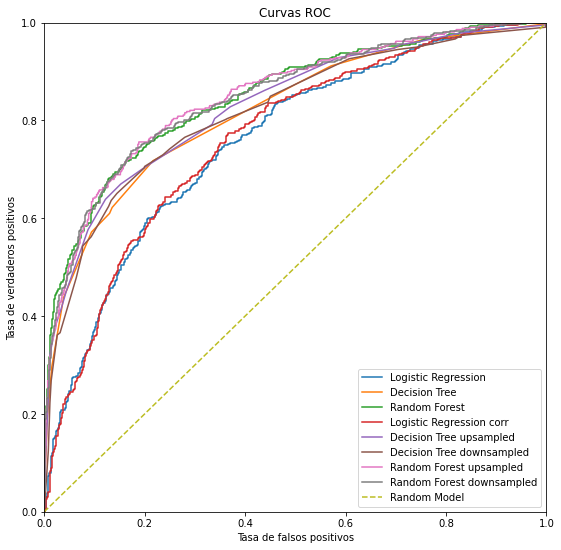

In [47]:
plt.figure(figsize=(9, 9))

plt.plot(fpr_reg_log, tpr_reg_log, label='Logistic Regression')
plt.plot(fpr_dec_tree, tpr_dec_tree, label='Decision Tree') 
plt.plot(fpr_rand_for, tpr_rand_for, label='Random Forest')  
plt.plot(fpr_reg_log1, tpr_reg_log1, label='Logistic Regression corr')
plt.plot(fpr_dec_tree2, tpr_dec_tree2, label='Decision Tree upsampled') 
plt.plot(fpr_dec_tree3, tpr_dec_tree3, label='Decision Tree downsampled') 
plt.plot(fpr_rand_for2, tpr_rand_for2, label='Random Forest upsampled') 
plt.plot(fpr_rand_for3, tpr_rand_for3, label='Random Forest downsampled') 
         
# Curva ROC para modelo aleatorio 
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC')
plt.legend()

plt.show()

Gráfica de curvas ROC para cada uno de los modelos optimizados. La líne naranja sesgada muestra la curva correspondiente a un modelo aleatorio, cuanto más arriba está la curva mejor es el modelo. Se observa que el modelo con los mejores resultados se obtienen con el modelo de Bosque Aleatorio. El modelo con mayor AUC ROC se logra con corrección por sobremuestreo.

### Modelo final
En base a los resultados anteriores, se aplica el modelo de Bosque Aleatorio, con codificación de etiquetas y sobremuestreo. Con número de estimadores 100 y profundidad máxima de 8.

In [58]:
features_train, features_valid, features_test, target_train, target_valid, target_test = segmentation(data_ordinal)

features_train, features_valid, features_test = scaling(features_train, features_valid, features_test)

In [59]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8)# establece el modelo de bosque
            
model.fit(features_upsampled, target_upsampled) 

RandomForestClassifier(max_depth=8, random_state=12345)

In [60]:
predicted_test = model.predict(features_test) #predice para el conjunto de validación
            
f1 = f1_score(target_test, predicted_test)

probabilities_test = model.predict_proba(features_test) #calcula las probabilidades
probabilities_one_test = probabilities_test[:, 1] #extrae las probabilidades 'exited'=1

auc = roc_auc_score(target_test, probabilities_one_test)

print('    F1               AUC ROC   ')
print(f1, auc)

    F1               AUC ROC   
0.6143187066974596 0.8538626323135017


## Conclusiones

Los modelos con correción para desequilibrio de clases se desempeñan mejor que los modelos sin corrección. El modelo con mayor puntaje f1 es el Bosque Aleatorio con corrección por submuestreo, sin embargo el que tiene el mejor puntaje AUC ROC es con sobremuestreo.

Para el modelo final se optó por el modelo de Bosque Aleatorio, con 100 estimadores y profundidad máxima de 8. Se utiliza codificación de etiquetas y corrección con sobremuestreo con 3 repeticiones. El puntaje final f1 es de 0.614 y el AUC ROC de 0.853.